# Recreation of adenine riboswitch DANCE analysis

Here I recreate the visualization done in Figure 2C of [this paper](https://doi.org/10.1016/j.molcel.2022.02.009).

In short, DMS-MaP was performed on the *V. ful* adenine riboswitch IVT construct in an absence of adenine ligand. DANCE-MaP analysis recapitulates the known states and populations of this riboswitch and provides direct evidence of the known secondary and tertiary interactions. This data is then used to accurately model each state of the ensemble.

To create the data files used here:

1) DMS-MaP was performed on the adenine riboswitch construct.
2) Illumina sequencing reads were given to ShapeMapper2.
3) ShapeMapper2 `parsed.mut` files were given to DanceMapper and foldClusters.

## Import RNAvigate

In [1]:
import rnavigate as MaP

## Load data

DanceMapper outputs files have a standard naming convention: a sample prefix followed by a suffix indicating the data type.
We provide RNAvigate with the sample prefix, and it will find all of the relevent data files.

Below, the default structure files are replaced with custom drawing files from StructureEditor. In addition,
the Translation ON state has a crystal structure and below this PDB structure file is added to the minor component of the DANCE-MaP model.

In [2]:
sample = MaP.Sample(sample="V.vul adeRS",
                    dance_prefix="wt_0_deep")

# replacing automatically generated names for each DANCE-MaP component
sample.dance[0].sample = f"Translation ON ({float(sample.dance_percents[0]):.1%})"
sample.dance[1].sample = f"Translation OFF ({float(sample.dance_percents[1]):.1%})"

# replacing ct structure files with nsd structure files
# These files contain the same information, but with drawing coordinates.
sample.dance[0].set_data(name="ct", filepath="wt_0_deep-0.nsd")
sample.dance[1].set_data(name="ct", filepath="wt_0_deep-1.nsd")

# the "Translation ON" crystal structure is associated with the 2nd dance component.
sample.dance[1].set_data(name="pdb", filepath="4tzx.pdb", chain="X")


## Make Arc plot for each DANCE component

c:\Users\psirv\Anaconda3\envs\RNAvigate\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
c:\Users\psirv\Anaconda3\envs\RNAvigate\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


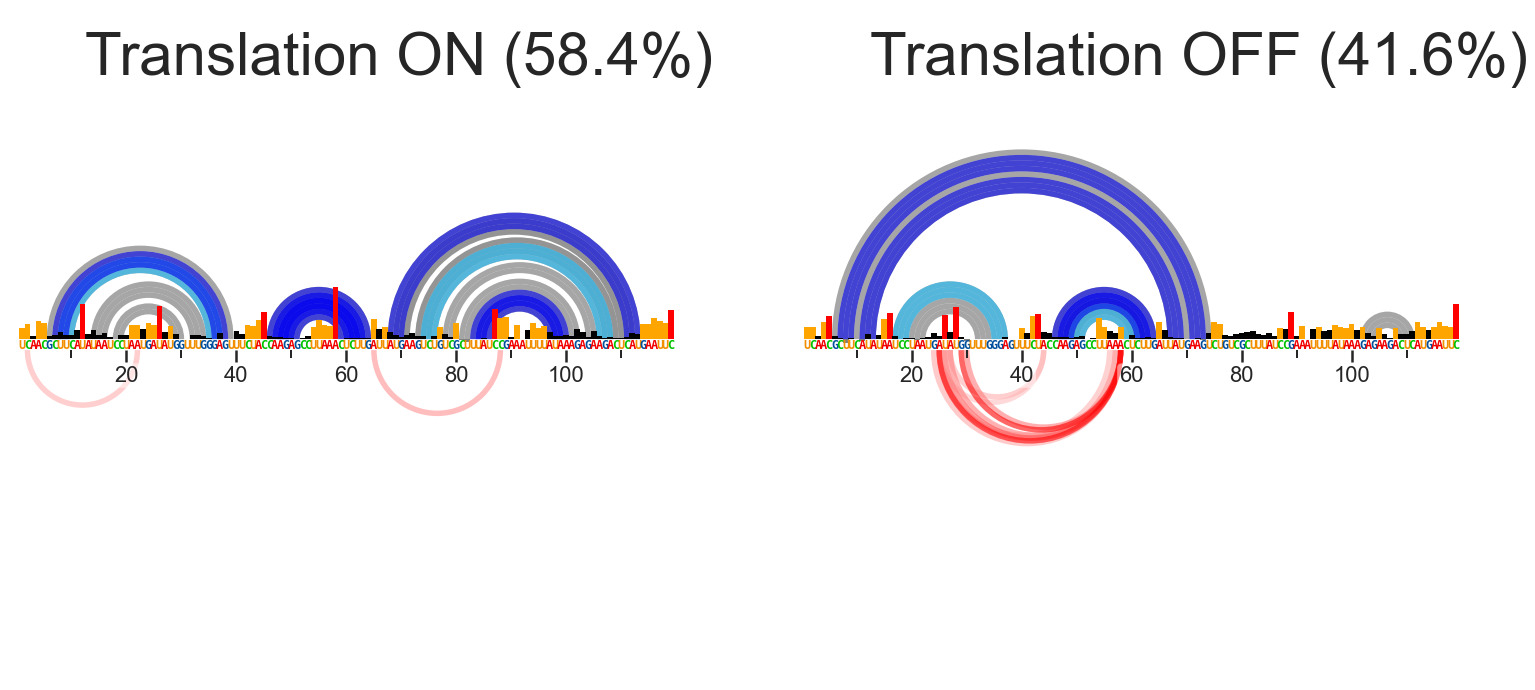

In [3]:
sample.dance_filter()
MaP.plot_arcs_multisample(
    samples=sample.dance,        # Make one plot per dance component
    prefiltered=True,            # Preserve the filtering applied above
    interactions="pairmap",      # Plot PAIR-MaP data...
    interactions_panel="top",    # on the top panel
    interactions2="ringmap",     # Plot RING-MaP data
    colorbar=False);             # Dont create a colorbar for RINGs/PAIRs

## Make secondary structure drawings for each component

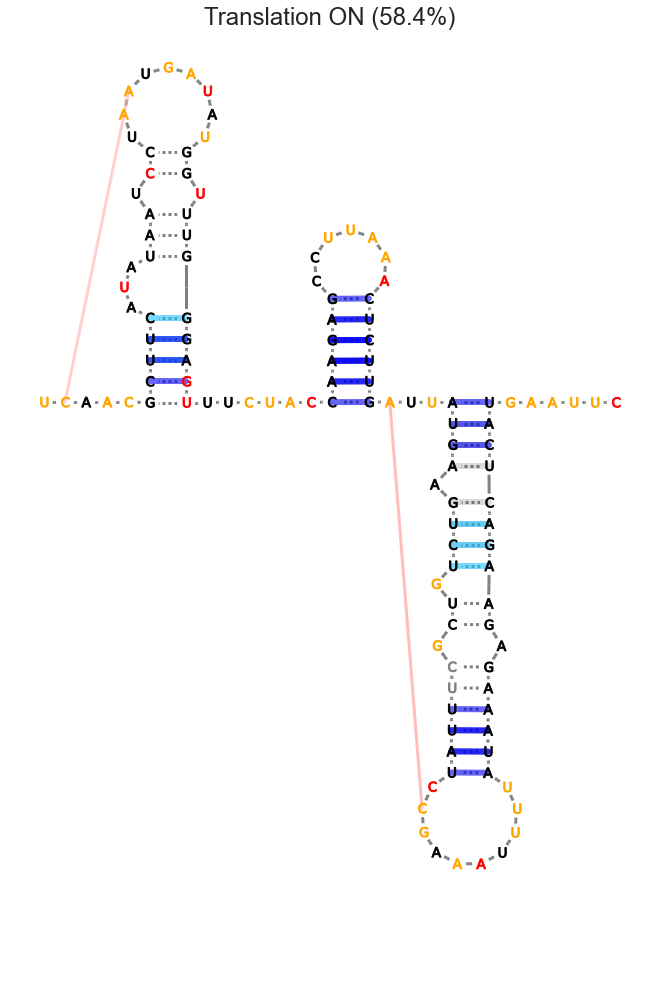

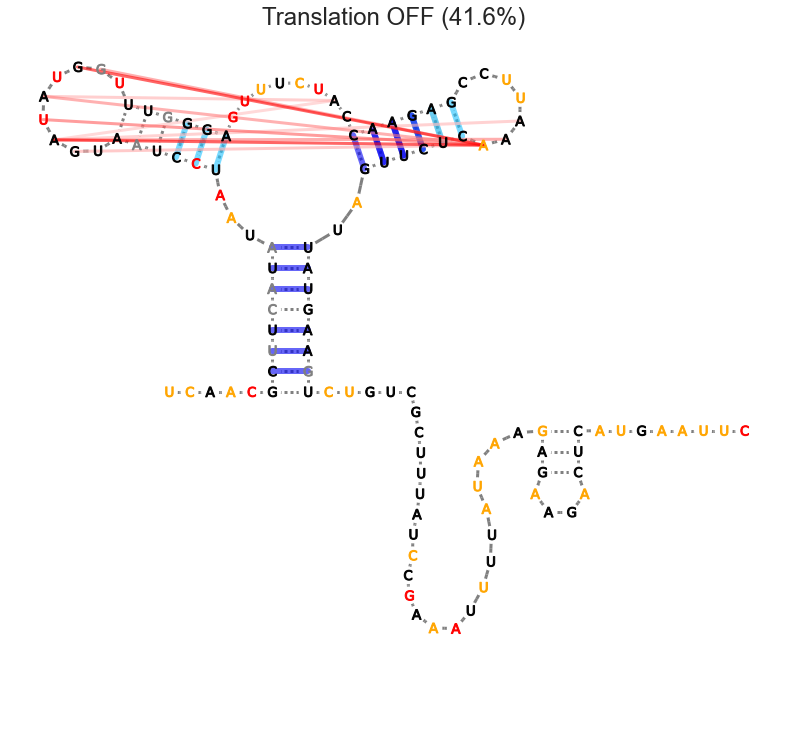

In [4]:
for component in sample.dance:
    component.plot_ss(prefiltered=True,               # maintain the dance filter applied earlier
                      ss="ct",                      # Use the structure drawing coordinates from the ct data
                      interactions="pairmap",         # plot PAIR-MaP data
                      interactions2="ringmap",        # and RING-MaP data
                      colors="profile",             # use shapemap reactivity colors
                      apply_color_to="sequence",    # applied to the sequence letters
                      colorbar=False);              # Don't show color bars for RINGs and PAIRs data

## Draw 3D structure with RINGs

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

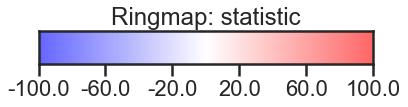

In [5]:
sample.dance[1].plot_mol(                         # make a 3D rendering of the ON state
    interactions="ringmap",                       # Draw RING-MaP data on structure
    interactions_filter={"cdAbove":15,            # require RINGs to be above 15 in contact distance
                         "positive_only":True,    # only plot positive correlations
                         "exclude_nts":[60]},     # remove spurious correlation at nucleotide 60
    nt_color="grey")                              # Color RNA in grey